#  __ __ __ __ __ Amirmohammad Khosravi Esfezar __ __ __ __ __ __
#  __ __ __ __ __ __ __ __ S.N. : 810198386 __ __ __ __ __ __ __ __ __

#  __ __ __ __ __ __ Project: Naive Bayes Classifier __ __ __ __ __ __

Classifing products of divar according to their description and title into 6 different categories.

# => Phase 0: Initializing and reading data

In [63]:
import pandas as pd
from __future__ import unicode_literals
from hazm import *
import collections
import math
import copy
import matplotlib.pyplot as plt

In [64]:
TRAIN_FILE_PATH = 'divar_train.csv'
TEST_FILE_PATH = 'divar_test.csv'

In [65]:
trainData = pd.read_csv(TRAIN_FILE_PATH)
testData = pd.read_csv(TEST_FILE_PATH)

# => Phase 1: Preprocessing

# => 1:
In preprocessing we use hazm library and its methods. We use lemmatization and stemming to normalize words.

**Lemmetization**: Replace words with their origins(roots). for example word 'میروم' will be converted to 'رفت#رو'.

**Stemming**: Deleting all extra characters from words. for example word 'کتاب ها' will be 'کتاب'.

Another thing we do is deleting prepositions, conjuctions, single character words, dots, commas and etc.
We use a lambda function that iterate throw all words and checks if the word exist in wordsToDelete 
list or not; if yes it will delete that word.
After that we normalize both train and test data (both description and title parts).

In [66]:
normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()
wordsToDelete = ['را', 'برای', 'به', 'با','که', 'از', 'در', 'اما','اگر', 'اگه', 'تا', 'هر','و', '.', 'و', 'نو']

def normalize(data):
    words = word_tokenize(data)
    for index, word in enumerate(words):
        words[index] = stemmer.stem(word)
        words[index] = lemmatizer.lemmatize(word)
    return list(filter(lambda word: word not in wordsToDelete and len(word) != 1, words))

trainData['description'] = trainData['description'].apply(normalize)
trainData['title'] = trainData['title'].apply(normalize)

testData['description'] = testData['description'].apply(normalize)
testData['title'] = testData['title'].apply(normalize)

# => Phase 2: Problem flow

# => 2:
$x$: words appeared

$c$: The product category

**Likelihood-->** $P(x|c)$ : Probability of seeing set of words $x$ in a description and title of product with category of $c$ 

**Posterior-->** $P(c|x)$ : Probability of the product category being $c$ knowing that set of words $x$ has appeared in the title and description. 

**Class Prior Probability-->** $P(c)$: Probability of seeing a prduct with category $c$ which is equal for all categories since they all have occured the same number of times in the dataset.

$$ P(c|x) = \frac{P(x|c)P(c)}{P(x)} $$

Here we count all words in train data for each category and save it in a dictionay called categorizedData.

In [67]:
categories = list(set(trainData['categories']))
categorizedData = {c:trainData[trainData.categories == c] for c in categories}
dataWordsCounts = {c:0 for c in categories}
for category in categorizedData:
    allWords = []
    categorizedData[category]['title'].apply(lambda i: allWords.extend(i))
    categorizedData[category]['description'].apply(lambda i: allWords.extend(i))
    tokenCounts = collections.Counter(allWords)
    totalWords = sum(tokenCounts.values())
    dataWordsCounts[category] = [tokenCounts, totalWords]

# Bigram
# => 3:
For example we have sentences below:

بوستان سعدی یکی از آثار ارزشمند فارسی است.

درختان جدیدی در بوستان کاشته شده اند.

In the first sentece بوستان is a book name and in the second one in means garden or park. 

If we use bigram we will get the meaning correctly because of words سعدی and کاشته which are after بوستان .

In [68]:
assessmentData = {
    'Correct Detected': 0, 
    'Total': 0, 
    'Correct Detected Class': {c:0 for c in categories}, 
    'All Detected Class': {c:0 for c in categories},
    'Total Class': {c:0 for c in categories},
}

def initializeAssessmentData():
    assessmentData['Correct Detected'] = 0
    assessmentData['Total'] = 0
    assessmentData['Correct Detected Class'] = {c:0 for c in categories}
    assessmentData['All Detected Class'] = {c:0 for c in categories}
    assessmentData['Total Class'] = {c:0 for c in categories}

Here we calculate probability for each category and predict the category for each product. For calculating probability for each category we use formula bellow:
$$ \frac{Word Counts + \alpha}{Total Words + \alpha.D} $$


In [69]:
def predictCategories():
    initializeAssessmentData()
    for i in testData.iloc:
        assessmentData['Total'] += 1
        allWords = i['title'] + i['description']
        categoriesProbability = {c:1 for c in categories}
        for c in categories:
            for w in allWords:
                wordCs = 0
                if w in dataWordsCounts[c][0].keys():
                    wordCs = dataWordsCounts[c][0][w]
                wordProb = wordCs / dataWordsCounts[c][1]
                categoriesProbability[c] *= wordProb
        mostProbab = c
        assessmentData['Total Class'][i['categories']] += 1
        for j in categoriesProbability.keys():
            if categoriesProbability[j] > categoriesProbability[mostProbab]:
                mostProbab = j
        if mostProbab == i['categories']:
            assessmentData['Correct Detected'] += 1
            assessmentData['Correct Detected Class'][i['categories']] += 1
        assessmentData['All Detected Class'][mostProbab] += 1

# Additive Smoothing
# => 4:
When there is a word which is only in one category, Naive Bayes will definetly choose that category as the predicted anser because the other categories probability will become zero, but this may cause wrong answers. 

When a word such as x is not in a category the probability (P(x|c)) will be zero so when we multiply it to the total probability of that category the result will be zero and will never be chosen as the answer.

# => 5:
We calculate the probability with the formula below in additive smoothing for each category:

$$ \frac{Word Counts + 1}{Total Words + 1 + Words Type Counts} $$

Using additive smoothing, we wont have those zero probability mentioned in part 4 because we have at least one on the top part of ther formula (if word counts be zero) so many wrong answers will be avoided. The accuracy without additive smoothing is about 40 percent but with additive smoothing its about 86 percent.

In [70]:
wrongAnsweredTests = []

def predictCategoriesAdditive():
    initializeAssessmentData()
    truePredicts = 0
    allProducts = 0
    for i in testData.iloc:
        assessmentData['Total'] += 1
        allProducts += 1
        allWords = i['title'] + i['description']
        categoriesProbability = {c:0 for c in categories}
        for c in categories:
            for w in allWords:
                wordCs = 0
                notInList = False
                if w in dataWordsCounts[c][0].keys():
                    wordCs = dataWordsCounts[c][0][w]
                else:
                    notInList = True
                if notInList:
                    wordProb = math.log((wordCs + 1) / (dataWordsCounts[c][1] + len(allWords) + 1))
                else:
                    wordProb = math.log(wordCs / dataWordsCounts[c][1])
                categoriesProbability[c] += wordProb
        mostProbab = c
        assessmentData['Total Class'][i['categories']] += 1
        for j in categoriesProbability.keys():
            if categoriesProbability[j] > categoriesProbability[mostProbab]:
                mostProbab = j
        if mostProbab == i['categories']:
            truePredicts += 1
            assessmentData['Correct Detected'] += 1
            assessmentData['Correct Detected Class'][i['categories']] += 1
        else:
            wrongAnsweredTests.append([allWords, mostProbab, i['categories']])
        assessmentData['All Detected Class'][mostProbab] += 1

# Check Correctness:
# => 6:
Here we plot five most common words in each category and delete ones which are in almost all plots (we put them in wordsToDelete list). This will help us to get better accuracy.

In [71]:
def plotCommons():
    for c in categories:
        mostCommons = dataWordsCounts[c][0].most_common(5)
        mostCommonsList = list(map(list, zip(*mostCommons)))
        fig = plt.figure(figsize = (10, 5))
        plt.bar(mostCommonsList[0], mostCommonsList[1], color ='blue',width = 0.4)
        plt.xlabel("Words")
        plt.ylabel("Counts")
        plt.title(c)
        plt.show()

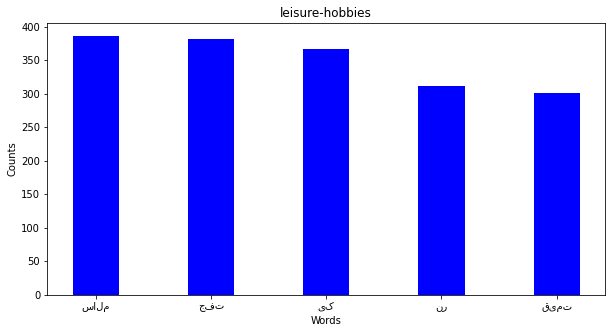

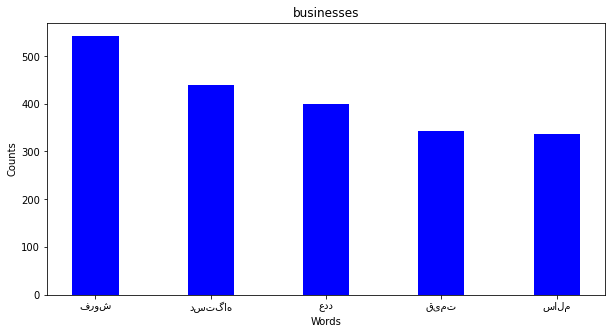

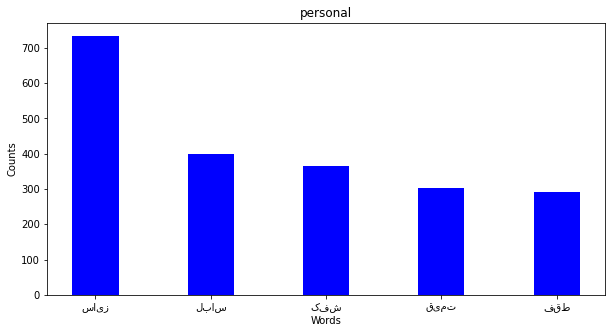

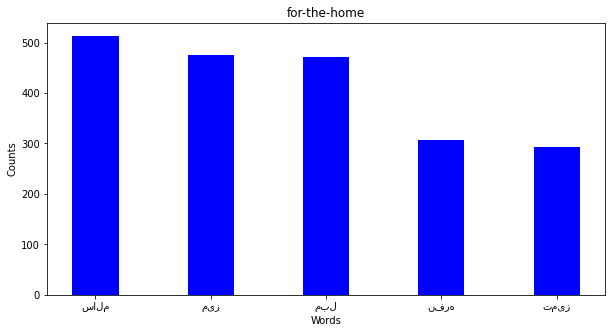

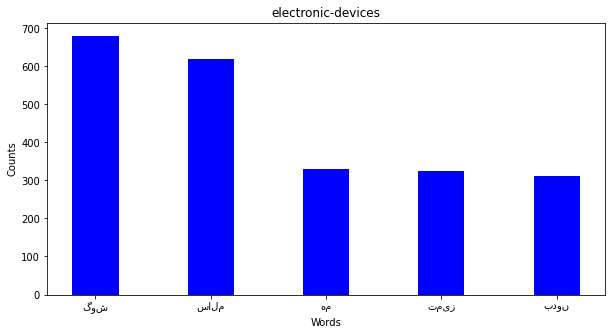

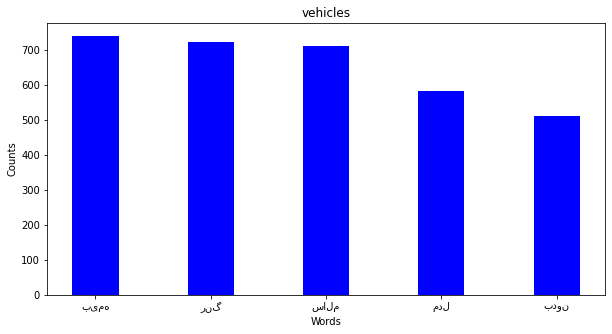

In [72]:
plotCommons()

In [73]:
assessment = {}
def calculateAssessment():
    assessment['Accuracy'] = assessmentData['Correct Detected'] / assessmentData['Total']
    assessment['Percision'] = {c:assessmentData['Correct Detected Class'][c] / assessmentData['All Detected Class'][c] for c in categories}
    assessment['Recall'] = {c:assessmentData['Correct Detected Class'][c] / assessmentData['Total Class'][c] for c in categories}
    assessment['F1'] = {c:2 * (assessment['Percision'][c] * assessment['Recall'][c]) / (assessment['Percision'][c] + assessment['Recall'][c]) for c in categories}

def printAssesment():
    calculateAssessment()
    print("Accuracy", " : ", assessment['Accuracy'] * 100, '\n')
    for c in categories:
        print("->>", c, "----------")
        print("Percision", " : ", assessment['Percision'][c] * 100)
        print("Recall", " : ", assessment['Recall'][c] * 100)
        print("F1", " : ", assessment['F1'][c] * 100, '\n')

# Phase 3: Assessment
# => 7:
Imagine a classifier which predict business for all products, the recall for category business is good but the classifier is not good actually cause the percision is not good. 

On the other hand imagine we predict 4 products category business and they are all true, so the precision is good and 100 percent but we have lost many other products with category business so  recall is low and our classifier didnt work properly. 

according to the above samples we need both recall and precision to check if our classifier works good or no.

# => 8:
**F1** is the harmonic mean of Precision and Recall. F1 takes both false positives and false negatives into account. F1 is usually more useful than accuracy, especially if you have an uneven class distribution. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall but if they have similar cost Accuracy works best.

$$Precision = \frac{True Positive}{True Positive + False Positive}$$

$$Recall = \frac{True Positive}{True Positive + False Negative}$$

$$F_{1} = 2\frac{Precision * Recall}{Precision + Recall} = \frac{True Positive}{True Positive + \frac{False Positive + False Negative}{2}}$$

# => 9:
**Micro**: computes f1 by value total true positives, false negatives and false positives.

**Macro**: calcluates f1 for each category and then returns the average without considering the proportion for each label in the dataset or we can say the weight is 1 for all.

**Weighted**: calculates f1 for each category and then returns the average considering the proportion for each category in the dataset which is actually weight of that category.

# Calculating micro, macro and weighted
Here we calculate micro, macro and weighted

In [74]:
avgs = {
    'Macro Avg': 0, 
    'Micro Avg': 0,
    'Weighted Avg': 0
}

def calculageAvgs():
    macroAvg = 0
    for a in assessment['F1'].keys():
        macroAvg += assessment['F1'][a]
    avgs['Macro Avg'] = macroAvg / 6
    
    weightedAvg = 0
    totalWeights = 0
    for a in assessment['F1'].keys():
        totalWeights += assessmentData['Total Class'][a]
        macroAvg += assessment['F1'][a] * assessmentData['Total Class'][a]
    avgs['Weighted Avg'] = macroAvg / totalWeights
    
    microAvg = 0
    correctCounts = 0
    totalClasses = 0
    for a in assessment['F1'].keys():
        correctCounts += assessmentData['Correct Detected Class'][a]
        totalClasses += assessmentData['Total Class'][a]
    avgs['Micro Avg'] = correctCounts / totalClasses
    
def printAvgs():
    calculageAvgs()
    print("******************")
    for a in avgs.keys():
        print(a, " --> ", avgs[a] * 100)
    print("******************")

# => 10: A)
# Results With Using Additive Smoothing

|        | Businesses | Electronic Devices | For the home | Leisure Hobbies | Personal | Vehicles | All Calsses |
| --- | --- | --- | --- | --- | --- | --- | --- |
| **Percision** | 78.52 | 89.73 | 77.61 | 91.24 | 87.82 | 94.60 | - |
| **Recall** | 78.0 | 90.33 | 89.0 | 83.33 | 89.0 | 87.66 | - |
| **F1-score** | 78.26 | 90.03 | 82.91 | 87.10 | 88.41 | 91.00 | - |
| **Accuracy** | - | - | - | - | - | - | 86.22 |
| **Macro Avg** | - | - | - | - | - | - | 86.28 |
| **Micro Avg** | - | - | - | - | - | - | 86.22 |
| **Weighted Avg** | - | - | - | - | - | - | 86.57 |

# => 10: B)
# Results Without Using Additive Smoothing

|        | Businesses | Electronic Devices | For the home | Leisure Hobbies | Personal | Vehicles | All Calsses |
| --- | --- | --- | --- | --- | --- | --- | --- |
| **Percision** | 76.57 | 88.52 | 86.04 | 90.54 | 91.58 | 22.45 | - |
| **Recall** | 28.33 | 18.0 | 37.0 | 22.33 | 32.66 | 98.66 | - |
| **F1-score** | 41.36 | 29.91 | 51.74 | 35.82 | 48.15 | 36.58 | - |
| **Accuracy** | - | - | - | - | - | - | 39.5 |
| **Macro Avg** | - | - | - | - | - | - | 40.60 |
| **Micro Avg** | - | - | - | - | - | - | 39.5 |
| **Weighted Avg** | - | - | - | - | - | - | 40.73 |

# => 11:
when we use additive smoothing the result improves and we have higher an better accuracy and averages. And also in every category percesion,  recall and F1 increased after using additive smoothing.

# => 12:
Without using additive smoothing some results are wrong because there is some unique words in test product which is only in one category so the probability for other categories are zero so the calssifier predicts wrong. So we check 5 wrong answers which are in classifer with additive smoothing:


# Five Wrong Answered Tests:

Product  0  -->  ['سیپوراکس', 'سیپوراکس', 'میکرو', 'مک', 'جی', 'بی', 'ال', 'سرامیک', 'سرا', 'کاهنده', 'نیترات', 'نیتریت', 'اکواریوم', 'درجه', 'یک']

Predicted category:  for-the-home

Real category:  leisure-hobbies

Product  1  -->  ['موتور', 'تزیین', 'جنس', 'اهن', 'کار', 'دست', 'عرضه', 'صورت', 'عمده', 'تک']

Predicted category:  businesses

Real category:  for-the-home

Product  2  -->  ['90', 'عدد', 'بشقاب', 'پیتزا', 'تک', 'نفره', 'قیمت', 'هرعدد', '4000', 'بشقاب', 'پیتزا', 'یک', 'نفره', 'عدد', '4000', 'باتشکراز', 'دیوار']

Predicted category:  for-the-home

Real category:  businesses

Product  3  -->  ['اچارشلاقی', 'HEYCOالمان', 'اصل', 'المان', 'سایز', '۱/۵', 'بسیار', 'مقاوم']

Predicted category:  personal

Real category:  businesses

Product  4  -->  ['فروش', 'تلفکس', 'سلام', 'تلفکس', 'پاناسونیک', 'تمیز', 'کم', 'کار']

Predicted category:  electronic-devices

Real category:  businesses

# Analysis:
As we can see in product 4 we have words more related to electronic-devices so our classifier answered electronic-devices but the true answer is business. Our classifier decided logicly and the product is confusing or categorized wrongly at first.

For product 2 the predicted category is for-the-home and it seems true but the true category is business and its not logical. So the classifier decided truely according to description and title.

In [75]:
def printWrongAnswered(n):
    print(len(wrongAnsweredTests))
    for i in range(min(n, len(wrongAnsweredTests))):
        print('Product ', i, ' --> ', wrongAnsweredTests[i][0])
        print('Predicted category: ', wrongAnsweredTests[i][1])
        print('Real category: ', wrongAnsweredTests[i][2])

In [76]:
def main():
    print('', "#" * 22, '\n', "# PREDICT CATEGORIES #\n", "#" * 22)
    predictCategories()
    printAssesment()
    printAvgs()
    print('', "#" * 46, '\n', "# PREDICT CATEGORIES WITH ADDITIVE SMOOTHING #\n", "#" * 46)
    predictCategoriesAdditive()
    printAssesment()
    printAvgs()
    printWrongAnswered(5)

In [77]:
main()

 ###################### 
 # PREDICT CATEGORIES #
 ######################
Accuracy  :  39.5 

->> leisure-hobbies ----------
Percision  :  90.54054054054053
Recall  :  22.333333333333332
F1  :  35.82887700534759 

->> businesses ----------
Percision  :  76.57657657657657
Recall  :  28.333333333333332
F1  :  41.3625304136253 

->> personal ----------
Percision  :  91.58878504672897
Recall  :  32.666666666666664
F1  :  48.15724815724816 

->> for-the-home ----------
Percision  :  86.04651162790698
Recall  :  37.0
F1  :  51.74825174825175 

->> electronic-devices ----------
Percision  :  88.52459016393442
Recall  :  18.0
F1  :  29.916897506925206 

->> vehicles ----------
Percision  :  22.458270106221548
Recall  :  98.66666666666667
F1  :  36.58838071693449 

******************
Macro Avg  -->  40.600364258055414
Micro Avg  -->  39.5
Weighted Avg  -->  40.735698805582274
******************
 ############################################## 
 # PREDICT CATEGORIES WITH ADDITIVE SMOOTHING #
 ####